# Benchmarking DenseDepth #

In [142]:
import os
import sys
import random
import subprocess

from skimage.transform import resize
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

#### Normalize Prediction and Ground Truth ####

Z score normalization applied to both predictions and truth.
Normalization is required to further compare errors among different datasets.

Visualize to check if the result is still valid -- should not visually differ much from non-normalized.

The following resize function is used to match dimensions
to the DeepDense NN input/output layer.

In [143]:
# For depth images call with resolution=240
# For color images call with resolution=480
def deepdense_resize(img: np.array, resolution=480) -> np.array:
    return resize(img, (resolution, int(resolution * 4 / 3)),
                  preserve_range=True, mode='reflect', anti_aliasing=True)

#### NYU Data Loader ####

NYU v2 dataset is available [here](https://drive.google.com/drive/folders/1TzwfNA5JRFTPO-kHMU___kILmOEodoBo).
Download and unzip to proceed with this notebook.

In [144]:
'''
Load NYU Dataset for evaluation.
    Args:
        path - path to nyu dataset test directory.
        count - how many images to load.
        return - a tuple of numpy arrays of rgb and corresponding depth images.
'''
def load_nyu_images(path: str, count=111) -> (np.array, np.array):

    # Collect image path
    rgb_img_path = []
    depth_img_path = []

    with os.scandir(path) as it:
        for entry in it:
            if not entry.name.startswith('.') and entry.is_file():
                if "colors.png" in entry.name:
                    rgb_img_path.append(entry.name)
                elif "depth.png" in entry.name:
                    depth_img_path.append(entry.name)

    rgb_img_path = [path + "/" + name for name in sorted(rgb_img_path)]
    depth_img_path = [path + "/" + name for name in sorted(depth_img_path)]

    rgb_img = [np.clip(np.asarray(Image.open(path), dtype=float) / 255, 0, 1) for path in rgb_img_path[:count]]
    depth_img = [np.asarray(Image.open(path), dtype=float) for path in depth_img_path[:count]]
    depth_img = [1000 / np.clip(1000 * img / np.max(img), 1, 1000) for img in depth_img]
    depth_img = [deepdense_resize(img, 240) for img in depth_img]
    # Normalize and invert depth
    depth_img = [(img - np.mean(img))/np.std(img) for img in depth_img]

    return np.stack(rgb_img), np.stack(depth_img)

#### Middlebury Data Loader ####

Middlebury Dataset is available [here](https://vision.middlebury.edu/stereo/data/scenes2014/).

Evaluation scenes downloaded and unzipped into the folder pointed by argument `path`.
Each sample of images is enclosed in a separate folder as follows:


The following loader method loads the default left view and the corresponding ground truth disparity map.

In [145]:
def load_middlebury_images(path: str, convert=False) -> (np.array, np.array):

    sample_path = []

    with os.scandir(path) as it:
        for entry in it:
            if not entry.name.startswith('.') and entry.is_dir():
                if "-perfect" in entry.name:
                    sample_path.append(entry.path)

    # Convert .pfm to .png requires magick
    if convert:
        for path in sample_path:
            subprocess.run(["magick", path + "/disp0.pfm", path + "/disp0.png"], check=True)

    rgb_img_path = [path + "/im0.png" for path in sample_path]
    depth_img_path = [path + "/disp0.png" for path in sample_path]

    rgb_img = [np.clip(np.asarray(Image.open(path), dtype=float) / 255, 0, 1) for path in rgb_img_path]
    rgb_img = [deepdense_resize(img, 480) for img in rgb_img]

    depth_img = [np.asarray(Image.open(path), dtype=float) for path in depth_img_path]
    depth_img = [np.clip(1000 * img / np.max(img), 1, 1000) for img in depth_img]
    depth_img = [deepdense_resize(img, 240) for img in depth_img]

    # Normalize depth
    depth_img = [(img - np.mean(img))/np.std(img) for img in depth_img]

    return np.stack(rgb_img), np.stack(depth_img)

#### Load Model ####

Get pretrained DeepDense model (~200MB) from [here](https://s3-eu-west-1.amazonaws.com/densedepth/nyu.h5).

In [146]:
# Path to the directory containing `layers.py`
sys.path.append("../models")
from densedepth import BilinearUpSampling2D

# Custom object needed for model inference..
custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D, 'depth_loss_function': None}
model = tf.keras.models.load_model("/Users/slava/Downloads/nyu.h5",
                                   custom_objects=custom_objects,
                                   compile=False)

## Predict NYU Depth ##
Run loaded NYU test images through the model to get predicted depth.

In [147]:
# Load Images
nyu_rgb, nyu_depth = load_nyu_images("/Users/slava/Downloads/nyu_data/data/nyu2_test")

In [148]:
# Predict Depth
nyu_prediction_depth = model.predict(nyu_rgb)

# Normalize Prediction
for i in range(nyu_prediction_depth.shape[0]):
    nyu_prediction_depth[i, ...] = (nyu_prediction_depth[i, ...] - np.mean(nyu_prediction_depth[i, ...]))\
                                    / np.std(nyu_prediction_depth[i, ...])

#### Visualize Prediction ####

Pick a random triple of images from the batch.

In [149]:
random_index = random.randrange(nyu_prediction_depth.shape[0])

Prediction Without Normalization


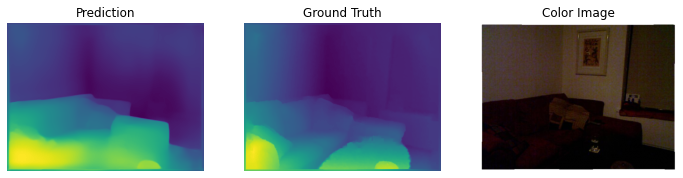

In [150]:
f, axarr = plt.subplots(ncols=3, figsize=(12, 8))

for ax in axarr:
    ax.axis("off")

print("Prediction Without Normalization")
axarr[0].set_title("Prediction")
axarr[0].imshow(nyu_prediction_depth[random_index, :, :, 0])

axarr[1].set_title("Ground Truth")
axarr[1].imshow(10 * nyu_depth[random_index, :, :])

axarr[2].set_title("Color Image")
axarr[2].imshow(nyu_rgb[random_index, :, :])

plt.show()

## Predict Middlebury Depth ##

In [151]:
# Load Images
mdbr_rgb, mdbr_depth = load_middlebury_images("/Users/slava/Downloads/middlebury-data")

In [152]:
# Predict Middlebury Depth
mdbr_prediction_depth = model.predict(mdbr_rgb)

In [153]:
# Normalize predicted depth.
for i in range(mdbr_prediction_depth.shape[0]):
    mdbr_prediction_depth[i, ...] = (mdbr_prediction_depth[i, ...] - np.mean(mdbr_prediction_depth[i, ...]))\
                                    / np.std(mdbr_prediction_depth[i, ...])

#### Visualize Prediction ####

Pick a random triple of images from the batch.

In [154]:
random_index = random.randrange(mdbr_prediction_depth.shape[0])

Prediction Normalized


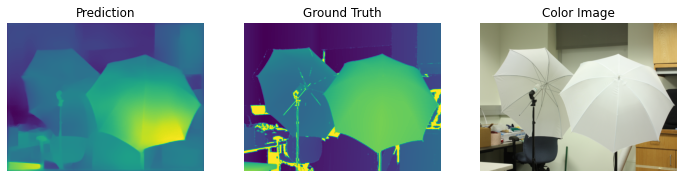

In [155]:
f, axarr = plt.subplots(ncols=3, figsize=(12, 8))

for ax in axarr:
    ax.axis("off")

print("Prediction Normalized")
axarr[0].set_title("Prediction")
axarr[0].imshow(mdbr_prediction_depth[random_index, :, :, 0])

axarr[1].set_title("Ground Truth")
axarr[1].imshow(mdbr_depth[random_index, :, :])

axarr[2].set_title("Color Image")
axarr[2].imshow(mdbr_rgb[random_index, :, :])

plt.show()

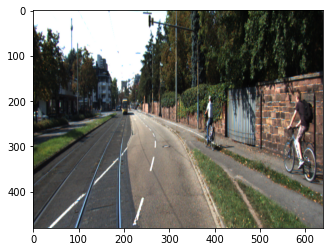